<a href="https://colab.research.google.com/github/amitpanwarIndia/DLOps/blob/main/M22AIE202_DLOps_ClassAssignment_02_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training with RMSprop optimizer:
Epoch [1/10], Loss: 4.3640, Accuracy: 0.2720
Epoch [2/10], Loss: 1.2042, Accuracy: 0.6220
Epoch [3/10], Loss: 0.9783, Accuracy: 0.7260
Epoch [4/10], Loss: 0.9237, Accuracy: 0.7310
Epoch [5/10], Loss: 0.8352, Accuracy: 0.7560
Epoch [6/10], Loss: 0.7560, Accuracy: 0.7810
Epoch [7/10], Loss: 0.7228, Accuracy: 0.7620
Epoch [8/10], Loss: 0.6696, Accuracy: 0.8030
Epoch [9/10], Loss: 0.6458, Accuracy: 0.8060
Epoch [10/10], Loss: 0.6255, Accuracy: 0.8050


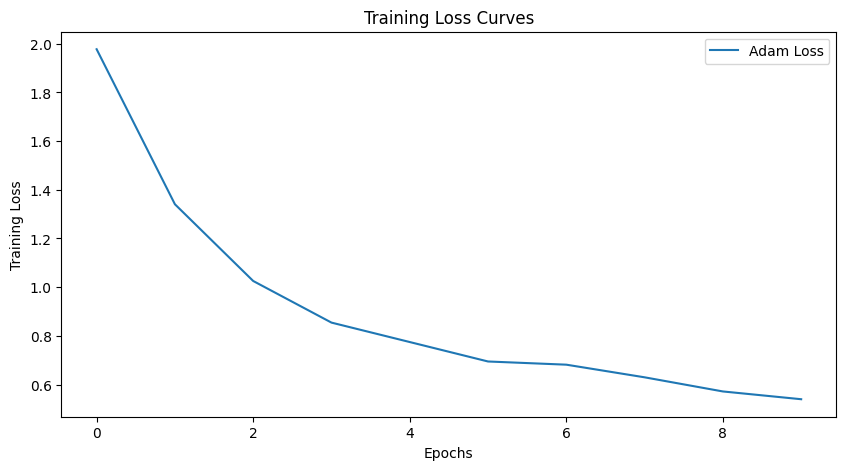

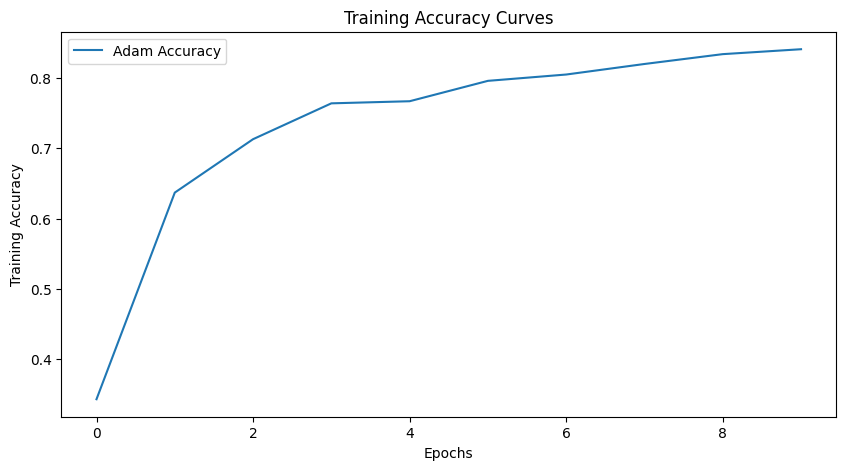

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

subsample_size = 1000

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)


indices = np.random.choice(len(train_dataset), size=subsample_size, replace=False)
train_dataset_subsample = Subset(train_dataset, indices)

train_loader = DataLoader(train_dataset_subsample, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model.fc.requires_grad = True

criterion = nn.CrossEntropyLoss()


#use any if it
optimizers = {
    'Adam': optim.Adam(model.parameters(), lr=0.001)
    #'Adadelta': optim.Adagrad(model.parameters(), lr=0.01),
    #'RMSprop': optim.RMSprop(model.parameters(), lr=0.001)
}

# Function to train the model
def train_model(model, optimizer, criterion, train_loader, device, num_epochs=10):
    train_loss_history = []
    train_acc_history = []

    model.train()
    model.to(device)  # Move model to the device

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    return train_loss_history, train_acc_history


for optimizer_name, optimizer in optimizers.items():
    print(f'Training with {optimizer_name} optimizer:')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_loss, train_acc = train_model(model, optimizer, criterion, train_loader, device, num_epochs=10)

plt.figure(figsize=(10, 5))
for optimizer_name, (train_loss, train_acc) in results.items():
    plt.plot(train_loss, label=f'{optimizer_name} Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for optimizer_name, (train_loss, train_acc) in results.items():
    plt.plot(train_acc, label=f'{optimizer_name} Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Curves')
plt.legend()
plt.show()

def test_model(model, test_loader):
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct_top1 += predicted.eq(labels).sum().item()
            _, predicted_top5 = outputs.topk(5, 1, largest=True, sorted=True)
            for i in range(labels.size(0)):
                if labels[i] in predicted_top5[i]:
                    correct_top5 += 1

    top1_accuracy = correct_top1 / total
    top5_accuracy = correct_top5 / total
    return top1_accuracy, top5_accuracy

top1_acc, top5_acc = test_model(model, test_loader)
print(f'Final Top-1 Test Accuracy: {top1_acc:.4f}')
print(f'Final Top-5 Test Accuracy: {top5_acc:.4f}')
